## Potential Talents Search - Candidates Ranking
As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

### Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

**Attributes:**
- id : unique identifier for candidate (numeric)
- job_title : job title for candidate (text)
- location : geographical location for candidate (text)
- connections: number of connections candidate has, 500+ means over 500 (text)

### Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

***Keywords:*** “Aspiring human resources” or “seeking human resources”


### Goal:
Predict how fit the candidate is based on their available information (variable fit)

### Success Metrics:
- Rank candidates based on a fitness score.
- Re-rank candidates when a candidate is starred.

### Bonuses:
- We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.
- How can we filter out candidates which in the first place should not be in this list?
- Can we determine a cut-off point that would work for other roles without losing high potential candidates?
- Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

### Importing Libraries

In [1]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import itertools for combinations
from itertools import combinations

# Import tensorflow and keras packages
import tensorflow as tf
from tensorflow.keras import layers, activations, Model, Input
from tensorflow.nn import leaky_relu
from tensorflow.keras.utils import plot_model, Progbar

### Loading the data

In [2]:
# Load dataset
df = pd.read_csv('datasets/potential_talents.csv', index_col = 'id')

# Inspect data
df.head()

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


### Exploring the data
For this project only *'job_title'* column is useful of the dataset, as it requires only text data. Rest of the data is useless for this task. However I decided to explore if It will be possible to gather any data from it.  
First I explore connections:

In [3]:
# Unique values in connections column
df.connection.unique()

array(['85', '500+ ', '44', '1', '61', '2', '390', '57', '82', '5', '7',
       '16', '212', '409', '52', '455', '174', '268', '50', '4', '40',
       '18', '349', '155', '39', '64', '9', '415', '19', '71', '48',
       '103', '49'], dtype=object)

There are not many unique values in this column. As it needs further investigation, the plot of counts of connections is built.

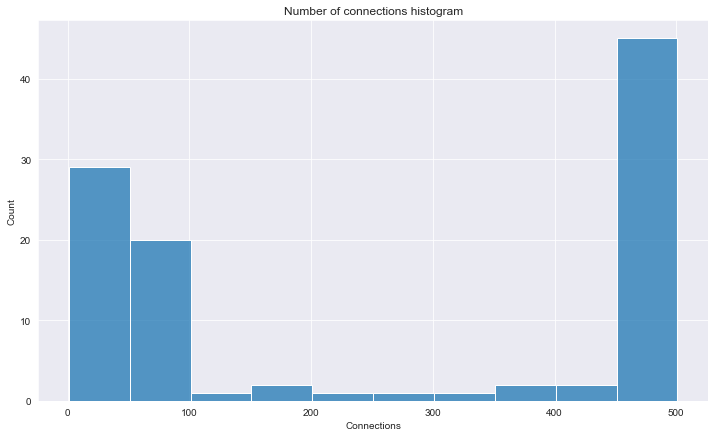

In [4]:
# Build histogram of number of connections
plt.figure(figsize = [12,7])
sns.set_style("darkgrid")
sns.histplot(df.connection.replace({'500+ ':'501'}).apply(int), bins = 10)
plt.xlabel("Connections")
plt.title("Number of connections histogram")
plt.show()

From chart its clear that most of candidates have over 500 connections. However, if group all people with conncetion under 100, they will be majority.  
Another interesting parameter to check is location of candidates. 

In [5]:
# Print unique values in location parameter
df.location.unique()

array(['Houston, Texas', 'Kanada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'İzmir, Türkiye', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'Amerika Birleşik Devletleri', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massa

Majority of candidates are from US, however the writing of location is inconsistent in many places. For some candidates location is town and state, while for other it is just a country. Ideally this data should be converted to one format (city, state, country or zip code) to be used.

I noticed that there are some duplicating entries in dataset, and decided to drop them:

In [6]:
# Drop duplicates
print("shape before:", df.shape)
df.drop_duplicates(inplace = True)
print("shape after:", df.shape)

# Reset index
df.reset_index(drop = True, inplace = True)

shape before: (104, 4)
shape after: (53, 4)


It appeared to be that half of entries are duplicating each other. So, the dataframe is half the size of original now.

## Cleaning the data
The main parameter in dataframe is `job_title`. However data in it is in raw form, it has commas, periods and other punctuation marks. As the split of sentences is done based on "space", these punctuation marks will disturb converting of words to word vectors. Regular **split()** method will not separate them from words. And when I will feed it to the word map, words wont be found in dictionary. It will decrease the content quality of my word vectors as not all words will be catched

Also some `job_titles` contain abbreviations that are important. It is necessary to preserve this information, so abbreviations must be replaced.

First I need to clean the `job_title` column from dots, commas, etc using `regex`. 



In [7]:
# Use regex to clean text and put it into 'job_title_cleaned' column 
df["job_title_cleaned"] = df["job_title"].str.replace("[+*,.|()${}&\-'!]", " ", regex = True)

Next I check all unique words in my dataset to see if there are any abbreviations or anything else that can create problems in training model

In [8]:
# Gather all words used in job titles for review
print(set(df["job_title_cleaned"].str.split().agg(sum, axis = 0)))

{'Woodlands', 'at', 'Opportunities', 'Guard', 'Customer', 'Passionate', 'Talent', 'Representative', 'a', 'Student', 'Schwan', 'leader', 'Team', 'Kokomo', 'ScottMadden', 'Executive', 'within', 'Bayar', 'Tobacco', 'is', 'Brand', 'Celal', 'Senior', 'Marketing', 'ENGIE', 'EY', 'Buckhead', 'Loparex', 'Intelligence', 'medical', 'Houston', 'Inc', 'Business', 'relocation', 'and', 'Analyst', 'Staffing', 'engaging', 'Delphi', 'Paint', 'Science', 's', 'Styczynski', 'for', 'International', 'Generalist', 'English', 'data', 'Louis', 'America', 'May', 'St', 'SVP', 'Teacher', '2020', 'Environmental', 'from', 'Excellence', 'Program', 'Systems', 'Officer', 'them', 'Recruiter', 'Seeking', 'National', 'Japan', 'Wellington', 'the', 'North', 'Atlanta', 'Procedures', 'State', 'Retired', 'An', 'Aspiring', 'Major', 'Hardware', 'work', '2621', 'Victoria', 'Partner', 'travel', 'or', 'Director', 'Retail', 'Positions', 'an', 'Beneteau', 'inclusive', 'helping', '709', 'T', 'employment', 'Recruiting', 'Success', 'En

There are some abbreviations that might mean something important like:
* CHRO
* GPHR
* SPHR
* HR
* HRIS

I am familiar with abbreviation of HR - human resources, and it is very important feature. I replaced these abbreviations to proper values from google

In [9]:
# Replace string values in dataframe
df["job_title_cleaned"] = df["job_title_cleaned"].str.replace("CHRO", " chief human resources officer ")
df["job_title_cleaned"] = df["job_title_cleaned"].str.replace("GPHR", " global professional in human resources ")
df["job_title_cleaned"] = df["job_title_cleaned"].str.replace("SPHR", " senior professional in human resources ")
df["job_title_cleaned"] = df["job_title_cleaned"].str.replace("HRIS", " human resources information system ")
df["job_title_cleaned"] = df["job_title_cleaned"].str.replace("HR", " human resources ")

After I cleaned my input text, it is time to convert sentences to the word vectors that best represent them.

## Work with text

I decided to approach this project using word embedding vectors.
- First I will convert each word in sentence to a vector. 
- Then I will get an average vector for the sentence.
- And, finally compare each sentence to my keyword sentences.  

To work with this text I chose `glove` word embeddings with 50-dimension. I chose the lowest dimension of glove to check the theory if it works. And if it will be successful higer dimension vectors might be tested.  
First I need to write a function that reads the **glove** file and transfers it's content to a dictionary named `words_vector_map`

In [10]:
# Create a function that reads a file and returns dictionary wher keys are words and values are vectors
def read_glove(glove_file):
    # open word vector file
    with open(glove_file, "r") as f:
        words_vector_map = {}
        
        # read each line of file and put it into dictionary
        for line in f:
            line = line.strip().split()
            words_vector_map[line[0]] = np.array(line[1:], dtype = np.float64)
    return(words_vector_map)

In [11]:
# Create words vector map
words_vector_map = read_glove("utils/glove.6B.50d.txt")

Next I convert sentences to the word vectors that best represent them. I will do it by taking average of all words vectors that are in each given sentence. Following steps should be performed:
- Covert each sentence to list of words
- For each of these words, if word is in *words dictionary* get it's value
- Get average of all words in sentence

In [12]:
# Create function that converts sentence to average vector
def sentence_to_avg(sentence, words_vector_map):
    # Initialize array of zeros of size of word vector
    shp = words_vector_map[list(words_vector_map.keys())[0]].shape
    s = np.zeros(shp) 
    
    # Strip sentence, change to lower case letters and split into words
    sentence = sentence.strip().lower().split()
    count = 0
    
    # Loop through words in sentence
    for word in sentence:
        # Check if word is in words_vector_map
        if word in words_vector_map:
            s += words_vector_map[word]
            count += 1
    # Return average by dividing sum to number of words 
    return(s/count)

To measure the similarity between two sentences, I need a way to measure the degree of similarity between two embedding vectors for the two sentences. Given two vectors *u* and *v*, cosine similarity is defined as follows:

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} $$

* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$

The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [13]:
def cos_similarity(u, v):
    # Dot product
    dp = np.dot(u, v)
    
    # Norms of u and v
    norm_u = np.sqrt(np.sum(u**2))
    norm_v = np.sqrt(np.sum(v**2))
    
    # Special case, if product of norms is 0:
    # avoids division by 0
    if np.isclose(norm_u * norm_v, 0, atol=1e-32):
        return 0
    
    # Computes cosine similarity
    cos_similarity = dp / (norm_u * norm_v)
    
    return(cos_similarity)

And now I need to put these functions together to automate the process:

In [14]:
# Create function that receives sentence and returns similarity to target sentence score
def calculate_sim(sentence):
    # Calculate sentence's average vector
    aver = sentence_to_avg(sentence, words_vector_map)
    
    # Compute similarity score of given sentence and target sentece
    similarity = cos_similarity(aver, target)
    return(similarity)

To test the function and to see how it ranks I chose first keyword sentence and run it to check how the dataset will be ranked

In [15]:
# Initialize target sentence
target_keyword = "Aspiring human resources"
target = sentence_to_avg(target_keyword, words_vector_map)

rank_df = df.copy()

# Apply my function to job titles in dataframe
rank_df["fit"] = rank_df["job_title_cleaned"].apply(calculate_sim)

# Rank data based on similarity
rank_df["rank"] = rank_df["fit"].rank(ascending = False)

# Print top 5 with highest rank
rank_df.sort_values(by = "rank").head()

,job_title,location,connection,fit,job_title_cleaned,rank
5,Aspiring Human Resources Specialist,Greater New York City Area,1,0.968802,Aspiring Human Resources Specialist,1.0
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,0.958368,Aspiring Human Resources Professional,2.5
45,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,0.958368,Aspiring Human Resources Professional,2.5
22,Human Resources Professional,Greater Boston Area,16,0.936910,Human Resources Professional,4.0
13,Seeking Human Resources Opportunities,"Chicago, Illinois",390,0.922567,Seeking Human Resources Opportunities,5.0


In [16]:
# Print 5 with lowest rank
rank_df.sort_values(by = "rank").tail()

,job_title,location,connection,fit,job_title_cleaned,rank
44,Student at Indiana University Kokomo - Busines...,"Lafayette, Indiana",19,0.550692,Student at Indiana University Kokomo Busines...,49.0
33,RRP Brand Portfolio Executive at JTI (Japan To...,Greater Philadelphia Area,500+,0.538585,RRP Brand Portfolio Executive at JTI Japan To...,50.0
43,Student at Westfield State University,"Bridgewater, Massachusetts",57,0.520403,Student at Westfield State University,51.0
9,Student at Chapman University,"Lake Forest, California",2,0.517071,Student at Chapman University,52.0
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,0.496264,Advisory Board Member at Celal Bayar University,53.0


## Ranking model. RankNet

This is neither classification nor regression problem. It is a ranking problem, so ranking algorithm should be applied. Ranking is very important concept, as it has vast range of uses. It is used in search results. Or in online shops for sorting products by relevance, movie recommendations etc.

The ranking problem I have is quite simple, and does not require big models. Simple RankNet should be enough for this project. Ranknet uses gradient descent methods for learning ranking functions. It has a simple probabilistic cost function, and implements these ideas using a neural network to model the underlying ranking function.

Ranking can be setup in following ways:
- Pointwise 
- Pairwise
- Listwise

RankNet proposed to model the target probabilities `pairwise` between any two documents (di & dj) of the same query. And the target probabilities Pij of di and dj is defined as:
- 1 if si > sj
- 0.5 if si=sj
- 0 if si < sj

where si and sj is the score of di and dj respectively. So now each pair of documents serve as one training record to RankNet.

I have job titles sentences vectors and their ranks. Now I need to convert it to pairs of sentences and their pairwise comparison target probabilities Pij. Following function does the job

In [17]:
# Function that receives sentence vectors and targets to return pairs of vectors and their probabilities Pij
def comb(X, y, jt):
    # Create combination pairs of indices
    idxs = list(combinations(range(X.shape[0]),2))
    np.random.shuffle(idxs)

    Xi = []
    Xj = []
    Pij = []
    job_titles = []
    pair_id = []

    # Create arrays Xi, Xj and target pairwise probabilites
    for i, j in idxs:
        Xi.append(X[i])
        Xj.append(X[j])
        job_titles.append([jt[i], jt[j]])
        pair_id.append([i, j])
        
        if y[i] < y[j]:
            Pij.append(1)
        elif y[i] > y[j]:
            Pij.append(0)
        else:
            Pij.append(0.5)

    # Convert data to numpy arrays
    Xi = np.array(Xi)
    Xj = np.array(Xj)
    Pij = np.array(Pij)
    
    return Xi, Xj, Pij, job_titles, pair_id


Next step is to get sentnce vectors from dataframe, calculate their similarities to target sentences. Also shuffle the data and split it to train and test sets. 

In [18]:
# Function that receives target sentence and dataframe, and returns all data necessary for neural network
def get_data(target_sentence, df):
    # Rank job title sentences based on their similarity to target sentence
    target = sentence_to_avg(target_sentence, words_vector_map)
    rank = df["job_title_cleaned"].apply(calculate_sim).rank(ascending = False)

    # Create temporary dataframe with sentence vectors
    t_f = lambda x: sentence_to_avg(x, words_vector_map)
    temp_df = pd.DataFrame(df['job_title_cleaned'].apply(t_f).to_list())

    # Add rank and job_title columns to dataframe
    temp_df.insert(50,"rank", rank)
    temp_df.insert(51,"job_title", df[['job_title']])

    # Shuffle the dataframe
    temp_df = temp_df.sample(frac = 1).reset_index(drop = True)

    # Get X and y from dataset. Convert them to numpy array. Also got job titles as series
    X = temp_df.drop(['rank', 'job_title'], axis = 1).values
    y = temp_df['rank'].astype('int').values
    jt = temp_df['job_title'].values
    
    # Split data to train and test sets
    len_train_df = int(X.shape[0] * 0.8)
    
    X_train, X_test = X[:len_train_df], X[len_train_df:]
    y_train, y_test = y[:len_train_df], y[len_train_df:]
    jt_train, jt_test = jt[:len_train_df], jt[len_train_df:]

    # Get combinations of features and probabilities of dataset
    Xi_train, Xj_train, Pij_train, job_titles_train, pair_id_train = comb(X_train, y_train, jt_train)
    Xi_test, Xj_test, Pij_test, job_titles_test, pair_id_test = comb(X_test, y_test, jt_test)
    
    return(Xi_train, Xi_test, Xj_train, Xj_test, Pij_train, Pij_test, job_titles_train, job_titles_test, pair_id_train, pair_id_test, jt_test, y_test)

Xi_train, Xi_test, Xj_train, Xj_test, Pij_train, Pij_test, job_titles_train, job_titles_test, pair_id_train, pair_id_test, jt_test, y_test = get_data("Aspiring human resources", df)

In [19]:
print(np.unique(Pij_train, return_counts=True))
print(np.unique(Pij_test, return_counts=True))

(array([0, 1]), array([440, 421]))
(array([0, 1]), array([40, 15]))


### RankNet implementation
Originally Ranknet was first developed and proposed by Microsoft, and paper can be downloaded [here](https://www.microsoft.com/en-us/research/wp-content/uploads/2005/08/icml_ranking.pdf).

It was described well in ***"medium"***, and can be read [here](https://medium.com/swlh/ranknet-factorised-ranknet-lambdarank-explained-implementation-via-tensorflow-2-0-part-i-1e71d8923132). The RankNet algorithm uses a neural network formulation. If we denote the neural network as function *f*, the output of neural network for document i as *oi*, the features of document i as *xi*. Hence we have *oi = f(xi) and oj = f(xj)*.  
So we can define:
$$ o_{ij} = o_i - oj = f(x_i) - f(x_j) = -(o_j - o_i) = -o_{ji} $$


Note that *oi* and *oj* could be any real number, but as mentioned above, RankNet is only modelling the probabilities *Pij* which is in the range of [0,1].  
In order to model the probabilities, logistic function is applied on *oij*.


While a typical neural network follows these steps to update its weights:  
*read input features -> compute output -> compute cost -> compute gradient -> back propagation*


RankNet update its weights as follows:  
*read input xi -> compute oi -> compute gradients doi/dWk ->  
read input xj -> compute oj -> compute gradients doj/dWk ->  
compute Pij -> compute gradients using equation (2) & (3) -> back propagation*  


So in RankNet, *xi & xj* serve as one training record, RankNet will pass *xi & xj* through the same the weights *(Wk)* of the network to get *oi & oj* before computing the gradient and update its weights.

2022-03-31 19:25:01.461799: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 19:25:01.504373: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


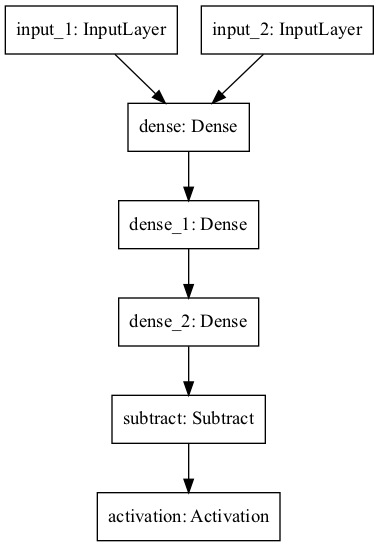

In [20]:
# Create the model
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.out = layers.Dense(1, activation='linear')
        self.sub = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.out(densei)
        oj = self.out(densej)
        oij = self.sub([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))

# Visualize model architecture
plot_model(RankNet().build_graph(), show_shapes=False)

Model architecture presented above illustrates how RankNet works. There are two input layer that take features of documents i and j. Then each of them go through two dense layers with 'leaky relu' activation and one dense layer with 'linear' activation function. Values of two resulting outputs of neural networks are subtracted one from another. And result of this subtraction go through 'sigmoid' activation function.

Next, I initialize the model with "Adam" optimizer and "binary crossentropy" as a loss function. Then run the model and assess losses of train and test sets. 

In [21]:
# Initialize the model
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')

In [22]:
# Run the model for 10 epochs
history = ranknet.fit([Xi_train, Xj_train], Pij_train, epochs=10, batch_size=1, validation_data=([Xi_test, Xj_test], Pij_test))

2022-03-31 19:25:05.010492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
861/861 [==============================] - 8s 4ms/step - loss: 0.3934 - val_loss: 0.1862
Epoch 2/10
861/861 [==============================] - 2s 2ms/step - loss: 0.1294 - val_loss: 0.1333
Epoch 3/10
861/861 [==============================] - 2s 2ms/step - loss: 0.1044 - val_loss: 0.1185
Epoch 4/10
861/861 [==============================] - 3s 4ms/step - loss: 0.0765 - val_loss: 0.1342
Epoch 5/10
861/861 [==============================] - 2s 3ms/step - loss: 0.0696 - val_loss: 0.1165
Epoch 6/10
861/861 [==============================] - 3s 3ms/step - loss: 0.0531 - val_loss: 0.1387
Epoch 7/10
861/861 [==============================] - 3s 3ms/step - loss: 0.0572 - val_loss: 0.1523
Epoch 8/10
861/861 [==============================] - 3s 3ms/step - loss: 0.0502 - val_loss: 0.1303
Epoch 9/10
861/861 [==============================] - 3s 3ms/step - loss: 0.0511 - val_loss: 0.1340
Epoch 10/10
861/861 [==============================] - 4s 4ms/step - loss: 0.0384 - val_loss: 0.1497

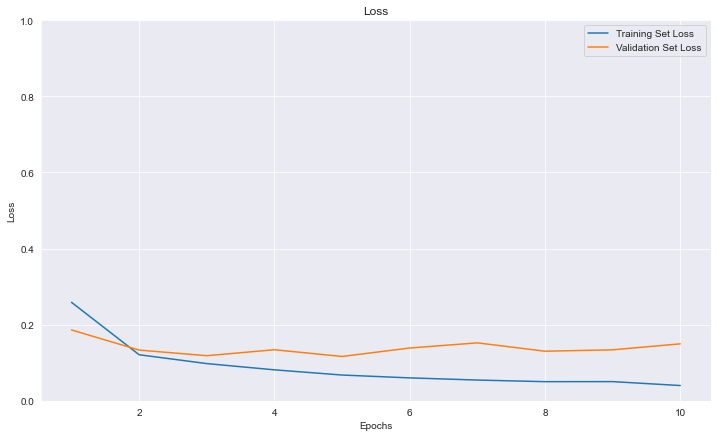

In [23]:
# Plotting losses
plt.figure(figsize = [12,7])

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")

sns.lineplot(x = range(1,1+len(history.history['loss'])), y = history.history['loss'])
sns.lineplot(x = range(1,1+len(history.history['loss'])), y = history.history['val_loss'])

plt.legend(labels = ['Training Set Loss', 'Validation Set Loss'])

plt.ylim(0,1)
plt.show()

Losses chart indicates that with epochs validation loss increases. It happens because more the model trains, better it fits the training set while validation set fitting worsens.

## Examining test set performance

Next, I try to predict ranks using test set and inspect quality of prediction.

In [24]:
# Make predictions
y_pred = ranknet.predict([Xi_test, Xj_test])

# Create dataset to compare predicted and original probabilities and text pairs
testset_df = pd.DataFrame({'job_titles':job_titles_test, 'y_test':Pij_test.reshape(-1), 'y_predicted':y_pred.reshape(-1)})
testset_df[['job_titles_1', 'job_titles_2']] = pd.DataFrame(testset_df['job_titles'].to_list())
testset_df.drop('job_titles', axis = 1, inplace = True)
testset_df.head(10)

,y_test,y_predicted,job_titles_1,job_titles_2
0,1,8.814073e-02,Human Resources professional for the world lea...,Human Resources Generalist at Schwan's
1,1,3.916363e-01,Senior Human Resources Business Partner at Hei...,"SVP, CHRO, Marketing & Communications, CSR Off..."
2,0,3.293732e-06,Aspiring Human Resources Management student se...,Seeking Human Resources Opportunities
3,0,2.250901e-02,Senior Human Resources Business Partner at Hei...,"Human Resources Generalist at ScottMadden, Inc."
4,1,1.000000e+00,Aspiring Human Resources Professional,"SVP, CHRO, Marketing & Communications, CSR Off..."
5,0,7.924501e-01,Human Resources Generalist at Schwan's,"SVP, CHRO, Marketing & Communications, CSR Off..."
6,0,5.047236e-12,Human Resources professional for the world lea...,Aspiring Human Resources Professional
7,1,9.959858e-01,Aspiring Human Resources Management student se...,"Human Resources Generalist at ScottMadden, Inc."
8,1,1.000000e+00,Human Resources Professional,"Human Resources Generalist at ScottMadden, Inc."
9,0,4.091476e-06,Seeking Human Resources HRIS and Generalist Po...,Aspiring Human Resources Professional


Predicted and original values of probabilities seems very consistent. Now I need a threshold to sort out if the predicted value should be 0 or 1. Most probably it should be 0.5, and the graph of accuracy vs threshold should prove it.

In [25]:
# Create function that calculates accuracies of predictions for different thresholds
def find_threshold(t_min, t_max, t_step, df):
    conv_func = lambda x: 1 if x > threshold else 0
    
    th_list = []
    acc_list = []
    
    for threshold in np.arange(t_min, t_max, t_step):
        y_converted = df['y_predicted'].apply(conv_func)
        diff = np.abs(df['y_test'] - y_converted)
        acc = 1  - diff.sum()/diff.shape[0]
        
        th_list.append(threshold)
        acc_list.append(acc)
    
    return th_list, acc_list

th_list, acc_list = find_threshold(0.1, 0.8, 0.01, testset_df)

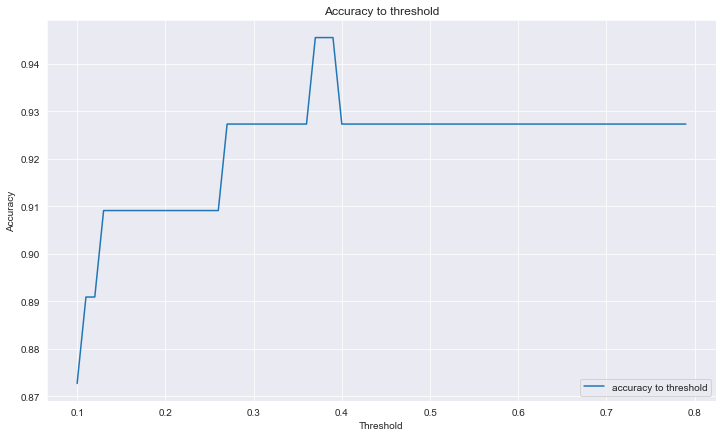

In [26]:
plt.figure(figsize = [12,7])
sns.lineplot(x = th_list, y = acc_list,label = 'accuracy to threshold')
plt.title("Accuracy to threshold")
plt.ylabel("Accuracy")
plt.xlabel("Threshold")
plt.legend(loc="lower right")
plt.show()

As we can see in this case there is not much of a difference in threshold we choose in whole range. So I chose `0.5` as the threshold for future.

Next step is to gain information from pairwise predictions. We cannot use it right away to assess how good the model performed. So, based on pairwise comparisons, using bubble sort algorithm I rank test set entries. Application of bubble sort algorithm is based on fact that sentences with higher similarity to target sentence will bewinning in pairwise comparison. Hence if I add points to each index for winning in comparison, highest points will get the sentence that ranks the best.

In [27]:
# Write a function to convert predicted values from sigmoid to 0 and 1's. Apply it to predicted values
conv_func = lambda x: 1 if x > 0.5 else 0
y_pred = testset_df['y_predicted'].apply(conv_func)

d = {}    

# Create zero values keys in dictionary for each index value from pair indices of test set
for i in np.unique(pair_id_test):
    d[i] = 0

# Loop through pair indices of test set, to identify strongest indices. Bubble sort
for i, pair in enumerate(pair_id_test):
    if y_pred[i]==0:
        d[pair[1]] += 1
    else:
        d[pair[0]] += 1

In [28]:
# Sort dictionary based on values (highest rank first). Then capture indices only from list of pairs
d = sorted(d.items(), key = lambda item: item[1], reverse = True)
predicted_indices = np.array(d)[:,0]

Now it is time to compare results to original test data. To get it done, I have list of ranks of test data. As I need only indices of theirs, sorted based on ranks, I need to perform some transformations of data.

In [29]:
# Enumerate list to get indeces of test set
y_test_enumerated = list(enumerate(y_test))

# Sort them based on rank, and preserve these indices in list
y_test_enumerated = sorted(y_test_enumerated, key = lambda x: x[1])
y_test_adjusted = [x[0] for x in y_test_enumerated]

# Create dataframe for assessing predicted ranks 
result_df = pd.DataFrame({'ranked_test_set':jt_test[y_test_adjusted], 'ranked_predicted_set':jt_test[predicted_indices]})
result_df.head(15)

,ranked_test_set,ranked_predicted_set
0,Aspiring Human Resources Professional,Aspiring Human Resources Professional
1,Human Resources Professional,Human Resources Professional
2,Seeking Human Resources Opportunities,Seeking Human Resources Opportunities
3,Seeking Human Resources HRIS and Generalist Po...,Seeking Human Resources HRIS and Generalist Po...
4,Aspiring Human Resources Management student se...,Aspiring Human Resources Management student se...
5,"Human Resources Generalist at ScottMadden, Inc.","Human Resources Generalist at ScottMadden, Inc."
6,Senior Human Resources Business Partner at Hei...,Human Resources Generalist at Schwan's
7,"SVP, CHRO, Marketing & Communications, CSR Off...","SVP, CHRO, Marketing & Communications, CSR Off..."
8,Human Resources professional for the world lea...,Senior Human Resources Business Partner at Hei...
9,Human Resources Generalist at Schwan's,Human Resources professional for the world lea...


From resulting dataframe it is clear that prediction did a good job. Predicted and test sets match each other well.

# Re-ranking dataset
One of the objectives of project is to re-rank candidates when a candidate is starred. I do it by changing ranks of candidates. Starred candidate will be highest in ranks and other will be changed accordingly. 
For my test I chose the job_title that just says `student`. This choice should bring up in rank all talents that have student in text. 

In [40]:
df[df['job_title']=='Student']

,job_title,location,connection,fit,job_title_cleaned
46,Student,"Houston, Texas Area",4,NaN,Student


In [55]:
# Rank job title sentences based on their similarity to target sentence
target = sentence_to_avg("Aspiring human resources", words_vector_map)
rank = df["job_title_cleaned"].apply(calculate_sim).rank(ascending = False)

# Add 1 to all of the ranks and then change rank of 'student'
rank += 1
rank[46] = 1

# Create temporary dataframe with sentence vectors
t_f = lambda x: sentence_to_avg(x, words_vector_map)
temp_df = pd.DataFrame(df['job_title_cleaned'].apply(t_f).to_list())

# Add rank and job_title columns to dataframe
temp_df.insert(50,"rank", rank)
temp_df.insert(51,"job_title", df[['job_title']])

# Shuffle the dataframe
temp_df = temp_df.sample(frac = 1).reset_index(drop = True)

# Get length of train set
len_train_df = int(temp_df.shape[0] * 0.8)

# I need to make sure that "Student is in training set"
idx = temp_df[temp_df['job_title']=='Student'].index[0]

while idx >= len_train_df:
    temp_df = temp_df.sample(frac = 1).reset_index(drop = True)
    idx = temp_df[temp_df['job_title']=='Student'].index[0]

# Get X and y from dataset. Convert them to numpy array. Also got job titles as series
X = temp_df.drop(['rank', 'job_title'], axis = 1).values
y = temp_df['rank'].astype('int').values
jt = temp_df['job_title'].values
    
# Split data to train and test sets
X_train, X_test = X[:len_train_df], X[len_train_df:]
y_train, y_test = y[:len_train_df], y[len_train_df:]
jt_train, jt_test = jt[:len_train_df], jt[len_train_df:]

# Get combinations of features and probabilities of dataset
Xi_train, Xj_train, Pij_train, job_titles_train, pair_id_train = comb(X_train, y_train, jt_train)
Xi_test, Xj_test, Pij_test, job_titles_test, pair_id_test = comb(X_test, y_test, jt_test)

In [56]:
# Initialize the model
re_ranknet = RankNet()
re_ranknet.compile(optimizer='adam', loss='binary_crossentropy')

In [57]:
# Run the model for 10 epochs
history = re_ranknet.fit([Xi_train, Xj_train], Pij_train, epochs=10, batch_size=1, validation_data=([Xi_test, Xj_test], Pij_test))

Epoch 1/10
861/861 [==============================] - 4s 3ms/step - loss: 0.3839 - val_loss: 0.1901
Epoch 2/10
861/861 [==============================] - 3s 4ms/step - loss: 0.1406 - val_loss: 0.2158
Epoch 3/10
861/861 [==============================] - 3s 3ms/step - loss: 0.1143 - val_loss: 0.1920
Epoch 4/10
861/861 [==============================] - 2s 2ms/step - loss: 0.0969 - val_loss: 0.1601
Epoch 5/10
861/861 [==============================] - 2s 2ms/step - loss: 0.0711 - val_loss: 0.1428
Epoch 6/10
861/861 [==============================] - 3s 4ms/step - loss: 0.0728 - val_loss: 0.2044
Epoch 7/10
861/861 [==============================] - 7s 8ms/step - loss: 0.0589 - val_loss: 0.2300
Epoch 8/10
861/861 [==============================] - 3s 4ms/step - loss: 0.0632 - val_loss: 0.2034
Epoch 9/10
861/861 [==============================] - 3s 3ms/step - loss: 0.0462 - val_loss: 0.2111
Epoch 10/10
861/861 [==============================] - 2s 2ms/step - loss: 0.0421 - val_loss: 0.2262

In [58]:
# Make predictions
y_pred = re_ranknet.predict([Xi_test, Xj_test])

# Write a function to convert predicted values from sigmoid to 0 and 1's. Apply it to predicted values
conv_func = lambda x: 1 if x > 0.5 else 0
y_pred = testset_df['y_predicted'].apply(conv_func)

d = {}    

# Create zero values keys in dictionary for each index value from pair indices of test set
for i in np.unique(pair_id_test):
    d[i] = 0

# Loop through pair indices of test set, to identify strongest indices. Bubble sort
for i, pair in enumerate(pair_id_test):
    if y_pred[i]==0:
        d[pair[1]] += 1
    else:
        d[pair[0]] += 1

# Sort dictionary based on values (highest rank first). Then capture indices only from list of pairs
d = sorted(d.items(), key = lambda item: item[1], reverse = True)
predicted_indices = np.array(d)[:,0]

# Enumerate list to get indeces of test set
y_test_enumerated = list(enumerate(y_test))

# Sort them based on rank, and preserve these indices in list
y_test_enumerated = sorted(y_test_enumerated, key = lambda x: x[1])
y_test_adjusted = [x[0] for x in y_test_enumerated]

# Create dataframe for assessing predicted ranks 
result_df = pd.DataFrame({'ranked_test_set':jt_test[y_test_adjusted], 'ranked_predicted_set':jt_test[predicted_indices]})
result_df.head(15)

,ranked_test_set,ranked_predicted_set
0,Aspiring Human Resources Professional,"Director of Human Resources North America, Gro..."
1,Seeking Human Resources HRIS and Generalist Po...,Native English Teacher at EPIK (English Progra...
2,Human Resources Management Major,Human Resources Management Major
3,Seeking Human Resources Opportunities. Open t...,Seeking Human Resources Opportunities. Open t...
4,Student at Humber College and Aspiring Human R...,Student at Humber College and Aspiring Human R...
5,Human Resources Generalist at Schwan's,Director Of Administration at Excellence Logging
6,Human Resources Specialist at Luxottica,Seeking Human Resources HRIS and Generalist Po...
7,"Director of Human Resources North America, Gro...",Aspiring Human Resources Professional
8,Director Of Administration at Excellence Logging,Human Resources Specialist at Luxottica
9,Always set them up for Success,Always set them up for Success


As you can see from results, potential talents that have student in title or somehow related to universities are now higher in rank. So by starring some of the talents, we can rank this type of people higher automatically.

## Conclusion

Objectives of this project was fully reached. I utilized different techniques in this project, including:
- Used word embeddings to solve sentence analogy problems
- Measured similarity between sentence vectors using cosine similarity
- Ranked sentences based on their similarities
- Implemented RankNet algorithm to rank candidates
- Prepared input data for pairwise comparison